In [11]:
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(format='[%(levelname)s] %(asctime)s:\t %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [12]:
import sys

if 'almop' not in ' '.join(sys.path):
    logging.info('Local module \'almop\' not found in system path. Appending...')
    sys.path.append('../almop')

In [39]:
import almop as al
import eurostat as es
import pandas as pd

In [29]:
# Downloading House Price Index data
hpi_raw = es.get_data_df('PRC_HPI_Q')

In [35]:
hpi_pl = hpi_raw.copy()   # Create another variable to prevent writing to `hpi_raw` on accident. 
hpi_pl = hpi_pl.loc[hpi_pl['geo\TIME_PERIOD'] == 'PL']
hpi_pl = hpi_pl.loc[hpi_pl['unit'] == 'RCH_Q']
hpi_pl = hpi_pl.loc[hpi_pl['purchase'] == 'TOTAL']
assert(len(hpi_pl) == 1)
hpi_pl.head()

,freq,purchase,unit,geo\TIME_PERIOD,2005-Q1,2005-Q2,2005-Q3,2005-Q4,2006-Q1,2006-Q2,...,2020-Q3,2020-Q4,2021-Q1,2021-Q2,2021-Q3,2021-Q4,2022-Q1,2022-Q2,2022-Q3,2022-Q4
373,Q,TOTAL,RCH_Q,PL,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,1.0,2.0,3.1,2.6,3.9,3.3,2.0,2.4,1.4


<Axes: >

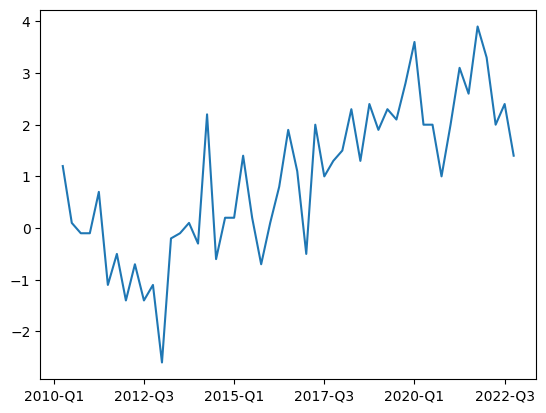

In [48]:
# Create a series from the first element using columns corresponding to time periods, hence [4:]
hpi_pl_series = pd.Series( hpi_pl.iloc[0].iloc[4:] )
hpi_pl_series.plot()